# **SetFitABSA vs. BloombergGPT**

### **BloombergGPT**

In their paper [BloombergGPT: A Large Language Model for Finance](https://arxiv.org/pdf/2303.17564.pdf), Bloomberg presents the development of **BloombergGPT**, LLM which is specialized for the financial domain.<br>
The model is a **50B** parameters language model, trained on a wide range of financial data:

*   **363 billion** tokens dataset based on Bloomberg's extensive data sources
*   **345 billion** tokens from general purpose datasets

The model was evaluated on various financial's NLP tasks, including Aspect-Based Sentiment Analysis (**ABSA**). This task was evaluated in an in-context manner by Bloomberg. They used [FiQA_SA](https://huggingface.co/datasets/AdaptLLM/finance-tasks/viewer/FiQA_SA) dataset for the evaluation - it contains test of 235 finance  sentences, each is prefixed by 5 tagged sentences, which overall comprise an input prompt to the model. Every tagged sentence in the prompt contains a known aspect and then a question is asked whether its corresponding polarity is Positive, Negative or Neutral, and the correct polarity is written at the end. Based on the 5 tagged sentences examples BloombergGPT is expected to predict the polarity of a given aspect in the test sentence. This is **SB2 ABSA task**, as the aspect is already given and the model just needs to predict the corresponding polarity.

The evaluation score achieved by this model is **weighted F1-score=75.07**, as reported in table 8 in the paper.

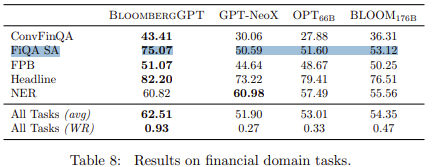

### **SetFitABSA**

[SetFitABSA](https://huggingface.co/blog/setfit-absa)
is a framework for **few-shot** training of domain-specific ABSA models. It provides an efficient and accurate technique to detect sentiment towards specific aspects within the text. The following shows evaluation results of a SetFitABSA model that was trained with just few k finance sentences and tested on the same 235 FiQA_SA test sentences used to evaluate BloombergGPT. The size of the model is based on its underlying sentence transformer and is usually smaller comparing to SOTA LLMs. Specifically, we were using for the comparison **paraphrase-mpnet-base-v2** sentence transformer, which its size is **110M** params comparing to **50B** of BloombergGPT.<br>
We separated from each prompt in [FiQA_SA](https://huggingface.co/datasets/AdaptLLM/finance-tasks/viewer/FiQA_SA) the tagged and non-tagged sentences, to create [train and test sets](https://huggingface.co/datasets/ronenlap/SetFitAbsa_FiQA) correspondingly. The train set contains 646 unique sentences overall.<br>This graph summarizes the evaluation results. It presents the weighted F1-score achieved by SetFitABSA as a function of K, the number of sampled training sentences. The result for each K is averaged over 5 seeds. We can see that with only 50 tranining sentences SetFitABSA exceeds BloombergGPT score. BTW, if we use the entire training set for training the model we get weighted F1-score over 86 (you can try it yourself with the code below).

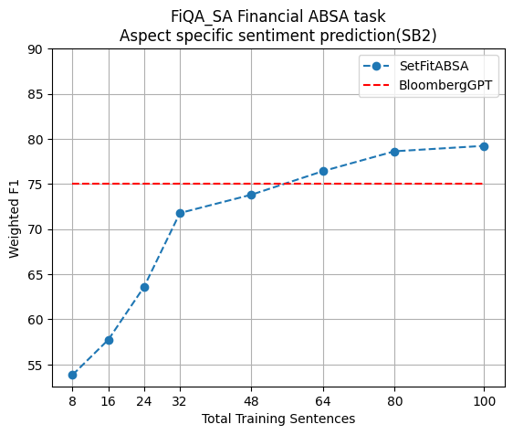

# **Demo Code**
The following code demonstrates the training of a SetFitABSA model and its evaluation over the **FiQA_SA** financial dataset.

Specifically:

*   We sample **k=24** sentences from the training set using an arbitrary seed
*   We trained a SetFitABSA model using just these **k** samples
*   We evaluate the trained model over the entire test set, exactly the same set that was used to evalute BloombergGPT model. The evaluated task is **SB2** - aspects are given and the model needs to predict their corresponding polarity

With just 24 training sentences we get weighted F1-score which is on par or better than the score 75.07 achieved by BloombergGPT (try it!)

### Install setfit with **SetFitABSA option**
We have to install SetFit as well as download a spaCy model for doing the initial aspect span candidate selection. We will download `en_core_web_lg`.

In [ ]:
!pip install -U "setfit[absa]"

In [ ]:
!python -m spacy download en_core_web_lg

### Import required packages

In [3]:
from setfit import AbsaTrainer, TrainingArguments, AbsaModel
from datasets import load_dataset
from sklearn.metrics import f1_score

### Load the **FiQA_SA** dataset

In [4]:
dataset = load_dataset("ronenlap/SetFitAbsa_FiQA")
train_ds = dataset["train"]
test_ds = dataset["test"]

In [5]:
train_ds

Dataset({
    features: ['sentence', 'aspect', 'polarity', 'ordinal'],
    num_rows: 670
})

In [6]:
train_ds[0]

{'sentence': '#Apple breaks major support, here are some levels to watch - http://stks.co/jRmW $AAPL $QQQ',
 'aspect': 'QQQ',
 'polarity': 'Negative',
 'ordinal': 0}

### Simulate the few-shot regime by sampling **k** text reviews for training

In [7]:
k = 24
seed = 35

In [8]:
experiment_ds = train_ds.shuffle(seed=seed).select(range(k))

In [28]:
experiment_ds

Dataset({
    features: ['sentence', 'aspect', 'polarity', 'ordinal'],
    num_rows: 24
})

### **Training a SetFitABSA Model**

#### Initialize an ABSA model
We'll initialize an AbsaModel using the strong [paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2) base model.

In [9]:
model = AbsaModel.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2",
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


#### Setting the training arguments

In [10]:
args = TrainingArguments(
    num_epochs=1,
    batch_size=4,
    num_iterations=20,
    save_strategy="no",
    report_to="none"
)

#### Creating a trainer object and executing the SetFitABSA model 
We need to apply a column mapping as the AbsaTrainer expects `"text"`, `"span"`, `"label"` and `"ordinal"` columns. The text refers to the sentence, whereas span is an aspect span in the sentence. The label is the corresponding label (e.g. "positive"), while ordinal is used to distinguish spans if they occur multiple times in the sentence. For example, if `"stock"` is the current aspect span, and it occurs 3 times in the sentence, an ordinal of `0` indicates that the sample is referring to the first occurrence.

In [11]:
trainer = AbsaTrainer(
    model,
    args=args,
    train_dataset=experiment_ds,  # if you want to train over the entire train set change experiment_ds to train_ds
    column_mapping={
        "sentence": "text",
        "aspect": "span",
        "polarity": "label",
        "ordinal": "ordinal",
    },
)

trainer.train()

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

***** Running training *****
  Num examples = 970
  Num epochs = 1
  Total optimization steps = 970
  Total train batch size = 4


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/970 [00:00<?, ?it/s]

{'aspect_embedding_loss': 0.435, 'learning_rate': 2.061855670103093e-07, 'epoch': 0.0}
{'aspect_embedding_loss': 0.23, 'learning_rate': 1.0309278350515464e-05, 'epoch': 0.05}
{'aspect_embedding_loss': 0.3388, 'learning_rate': 1.9931271477663232e-05, 'epoch': 0.1}
{'aspect_embedding_loss': 0.3288, 'learning_rate': 1.8785796105383734e-05, 'epoch': 0.15}
{'aspect_embedding_loss': 0.0135, 'learning_rate': 1.764032073310424e-05, 'epoch': 0.21}
{'aspect_embedding_loss': 0.0006, 'learning_rate': 1.6494845360824743e-05, 'epoch': 0.26}
{'aspect_embedding_loss': 0.0006, 'learning_rate': 1.534936998854525e-05, 'epoch': 0.31}
{'aspect_embedding_loss': 0.0002, 'learning_rate': 1.4203894616265753e-05, 'epoch': 0.36}
{'aspect_embedding_loss': 0.0003, 'learning_rate': 1.3058419243986255e-05, 'epoch': 0.41}
{'aspect_embedding_loss': 0.0007, 'learning_rate': 1.191294387170676e-05, 'epoch': 0.46}
{'aspect_embedding_loss': 0.0002, 'learning_rate': 1.0767468499427262e-05, 'epoch': 0.52}
{'aspect_embedding_

***** Running training *****
  Num examples = 240
  Num epochs = 1
  Total optimization steps = 240
  Total train batch size = 4


{'train_runtime': 138.2197, 'train_samples_per_second': 28.071, 'train_steps_per_second': 7.018, 'epoch': 1.0}


  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

{'polarity_embedding_loss': 0.4415, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.0}
{'polarity_embedding_loss': 0.1503, 'learning_rate': 1.7592592592592595e-05, 'epoch': 0.21}
{'polarity_embedding_loss': 0.0051, 'learning_rate': 1.2962962962962964e-05, 'epoch': 0.42}
{'polarity_embedding_loss': 0.0012, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.62}
{'polarity_embedding_loss': 0.0004, 'learning_rate': 3.7037037037037037e-06, 'epoch': 0.83}
{'train_runtime': 34.0637, 'train_samples_per_second': 28.182, 'train_steps_per_second': 7.046, 'epoch': 1.0}


Now, when training has completed,  `model` is a trained ABSA model.

### **Evaluation**
As we mentioned above, the evaluated ABSA task is SB2 - aspects are given and the model just needs to predict their corresponding polarity.

SetFitABSA supports this by providing the `predict` method with a dataset in a similar format as required for training, minus the `label` column. 

In [12]:
# rename columns according to predict() requirements
test_ds = test_ds.rename_columns({"sentence": "text","aspect": "span"})

In [13]:
output  = model.predict(test_ds) # a new column which holds the predicted polarity, "pred_polarity", is added to the dataset
output

Dataset({
    features: ['text', 'span', 'polarity', 'ordinal', 'pred_polarity'],
    num_rows: 235
})

Then, we can compute the weighted F1 score by taking both the gold polarity and the predicted polarity.

In [14]:
weighted_f1_score = f1_score(output["polarity"], output["pred_polarity"], average="weighted")
print(f"weighted_f1_score: {weighted_f1_score}")

weighted_f1_score: 0.7819641265152422


### **Inference**
Now that we've trained and evaluated the model, let's also try it out with some examples to get an intuitive feel of the model as well.

In [27]:
sentences = [
    "#Tesla: Model X Recall Adds To Reliability Issues $TSLA https://t.co/jVXQ4DoXnP",
    "$CIEN seems to have broken out of a major horizontal resistance. Targets $14.35.",
    "$AAPL I am big OUT from this. seems its falling towards 530.. :(",
]

model.predict(sentences)

[[{'span': 'Tesla', 'polarity': 'Negative'}],
 [{'span': 'CIEN', 'polarity': 'Positive'}],
 [{'span': 'AAPL', 'polarity': 'Negative'}]]